In [58]:
%%capture
%run ../WRF/read_wrf_helen.ipynb
%run ../confg

In [59]:
"""Compare different models (ICON, AROME, UKMO, WRF_ACINN) with radiosonde, in one plot with pressure as y-variable"""
import warnings

import xarray as xr

import metpy
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import wrf
from matplotlib import pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from netCDF4 import Dataset
from datetime import timedelta

warnings.filterwarnings("ignore")

In [60]:
def read_radiosonde_wrf_acinn():
    """
    read wrf data like a radiosounding for vertical cross section?
    """
    
    # Initialize an empty list to collect data
    all_data = []
    
    # Initialize a list to collect time values (timestamps)
    times = []

    # Loop through each day (15 and 16)
    for day in [15, 16]:
        # Define the hour range depending on the day
        if day == 15:
            # For day 15, loop from 12:00 to 24:00 (exclusive, i.e., 12-23)
            hour_range = range(12, 24)
        elif day == 16:
            # For day 16, loop from 00:00 to 12:00 (exclusive, i.e., 00-11)
            hour_range = range(0, 12)

        # Loop through each hour and half-hour within the range
        for hour in hour_range:  # Hour range: 12-24 for day 15, 00-12 for day 16
            for minute in [0, 30]:  # Minute increments: 0 and 30 (half-hour intervals)
                # Create a timestamp for this specific day, hour, and minute
                timestamp = pd.Timestamp(f"2017-10-{day:02d} {hour:02d}:{minute:02d}:00")
                
                # Read data for each fixed point and time
                df_acinn15 = read_wrf_fixed_point_and_time(
                    day=day,
                    hour=hour,
                    minute=minute,
                    latitude=station_files_zamg["LOWI"]["lat"],
                    longitude=station_files_zamg["LOWI"]["lon"]
                )

                # Add the timestamp to the 'times' list (for the current data entry)
                times.append(timestamp)

                # Collect the data
                all_data.append(df_acinn15)

    # Concatenate all data along the "time" dimension
    df_acinn = xr.concat(all_data, dim="time")

    # Now that we've concatenated all the data, we can assign the correct time coordinates
    # Ensure that the number of timestamps in 'times' matches the 'time' dimension in df_acinn
    if len(times) == len(df_acinn.time):
        df_acinn.coords["time"] = ("time", times)
    else:
        raise ValueError(f"Mismatch in time length: {len(times)} timestamps, but {len(df_acinn.time)} time steps.")

    # Return the accumulated xarray dataset
    return df_acinn


In [61]:
wrf_ds = read_radiosonde_wrf_acinn()
wrf_ds

<xarray.Dataset> Size: 200kB
Dimensions:            (time: 48, bottom_top: 80)
Coordinates:
    west_east          float64 8B -3e+03
    south_north        float64 8B -4e+03
  * time               (time) datetime64[ns] 384B 2017-10-15T12:00:00 ... 201...
Dimensions without coordinates: bottom_top
Data variables: (12/13)
    p                  (time, bottom_top) float32 15kB 9.63e+04 ... 4.283e+03
    th                 (time, bottom_top) float32 15kB 302.3 302.3 ... 514.9
    q_mixingratio      (time, bottom_top) float32 15kB 0.007096 ... 2.886e-06
    u                  (time, bottom_top) float32 15kB 0.08642 ... 0.7245
    v                  (time, bottom_top) float32 15kB -0.3619 ... -0.2622
    z                  (time, bottom_top) float32 15kB 592.9 614.4 ... 2.16e+04
    ...                 ...
    temperature        (time, bottom_top) float32 15kB 25.89 25.67 ... -63.84
    relative_humidity  (time, bottom_top) float32 15kB 32.52 32.54 ... 1.734
    dewpoint           (time, bottom_top) float32 15kB 8.191 8.005 ... -89.85
    specific_humidity  (time, bottom_top) float32 15kB 7.046 6.975 ... 0.002886
    ff                 (time, bottom_top) float32 15kB 0.3721 0.3721 ... 0.7705
    dd                 (time, bottom_top) float32 15kB 346.6 346.6 ... 289.9

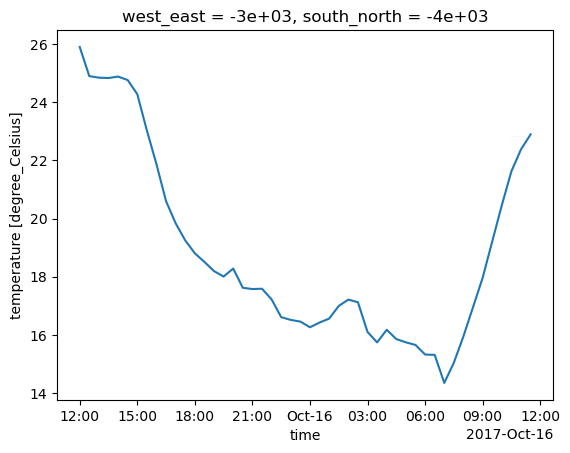

In [62]:
wrf_ds["temperature"].isel(bottom_top=0).plot()

# 2d temp time plot from wrf data
wrf_ds["temperature"].plot(x = "time", y = "bottom_top", figsize=(12,6), cmap='RdBu_r', vmin= -20, vmax= 20)  # .isel(time = wrf_ds.time[0])

In [ ]:
# for what is this good when i can use the above code?
temp_wrf = np.zeros(len(wrf_ds.temperature))
for i in range(len(wrf_ds.temperature)):
    temp_wrf[i] = (wrf_ds.temperature[i][0].values)
temp_wrf.size

In [ ]:
plt.plot(wrf_ds.time, temp_wrf);